In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import statsmodels.api as sm

# Need to move TRANSFORMERS and text_to_code_q6 to other script
from build_model_multinomial import TRANSFORMERS, text_to_code_q6, text_to_code_q10_2_binary
from build_model_logistic import build_v2g_model_binary_from_df
from get_data import init_column_map, pull_data_rowwise

In [2]:
# Define all variable categories
from variables import (
    demographics, input_variables_vehicle_ownership, familiarity, kms_driven, renewables_at_home,
    parking, q6a_cols, energ_literacy, renewables_at_home, intent_to_purchase_vehicle,
    benefits_v2g, concerns_v2g, interest_in_services, consider_using_NRMA_for,
    charging_control, preference_on_batt_use, expected_return,
    q6a_petrol, q6a_ev, q6a_plughyb, q6a_hybrid,
    feature_label_map
)

# 2. Model Setup

## 2.1. Initialise dataframe

In [3]:
csv_file = './data/survey_pre_processed_data.csv'

In [4]:
target_variable = 'Q10_2'  # "I would be interested in installing V2G..."

In [5]:
q10_2_categories = [
    "Strongly disagree",
    "Somewhat disagree",
    "Neither agree nor disagree",
    "Somewhat agree",
    "Strongly agree"
    ]

In [6]:
# Pull the data from CSV
init_column_map(csv_file)

# TBD -> Make function here
columns_of_interest = (
    familiarity +
    kms_driven + 
    renewables_at_home + 
#    q6a_cols + 
    demographics + 
    input_variables_vehicle_ownership + 
    parking + 
    benefits_v2g + 
    concerns_v2g +
    energ_literacy +
    [target_variable]
    )

rows = pull_data_rowwise(columns_of_interest, csv_file)

# Make a DataFrame
df = pd.DataFrame(rows, columns=columns_of_interest)
df

,Q9,Q2,Q8_1,Q8_2,Q8_99,gender,colour_plus,region,Q20,Q21,...,Q15_6,Q15_7,Q15_8,Q15_9,Q15_10,Q15_99,Q7_1,Q7_2,Q7_3,Q10_2
0,Somewhat familiar,"Less than 10,000",1,0,0,Male,LILAC,METROPOLITAN,2,Freestanding house,...,1,0,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,Neither agree nor disagree
1,Very familiar,"Less than 10,000",1,1,0,Male,LILAC,RURAL,2,Freestanding house,...,0,0,0,0,0,1,Strongly agree,Strongly agree,Somewhat agree,Strongly agree
2,Not at all familiar,"20,001-50,000",0,0,1,Not Stated,KHAKI,INTERSTATE,2,Townhouse,...,0,0,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,Strongly disagree
3,Not at all familiar,"Less than 10,000",0,0,1,Male,PURPLE,METROPOLITAN,2,Freestanding house,...,0,0,0,0,0,0,Somewhat disagree,Somewhat disagree,Somewhat agree,Somewhat disagree
4,Very familiar,"20,001-50,000",1,1,0,Male,PURPLE,INTERSTATE,3,Freestanding house,...,0,1,0,0,0,0,Strongly agree,Strongly agree,Somewhat agree,Somewhat agree
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,Somewhat familiar,"10,000-20,000",1,1,0,Female,KHAKI,REGIONAL,2,Townhouse,...,1,1,0,0,0,0,Strongly agree,Strongly agree,Neither agree nor disagree,Strongly agree
1354,Somewhat familiar,"Less than 10,000",0,0,1,Male,LILAC,REGIONAL,2,Apartment/unit,...,0,0,1,0,1,0,Strongly agree,Somewhat agree,Somewhat agree,Neither agree nor disagree
1355,Very familiar,"10,000-20,000",1,0,0,Male,GREY,REGIONAL,2,Freestanding house,...,0,1,0,0,1,0,Strongly agree,Neither agree nor disagree,Neither agree nor disagree,Strongly agree
1356,Very familiar,"10,000-20,000",0,0,1,Male,LILAC,RURAL,1,Other (please specify),...,0,0,0,0,1,0,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,Somewhat agree


In [7]:
df = df[df['Q1_2'] == '1']

In [8]:
df

,Q9,Q2,Q8_1,Q8_2,Q8_99,gender,colour_plus,region,Q20,Q21,...,Q15_6,Q15_7,Q15_8,Q15_9,Q15_10,Q15_99,Q7_1,Q7_2,Q7_3,Q10_2
1,Very familiar,"Less than 10,000",1,1,0,Male,LILAC,RURAL,2,Freestanding house,...,0,0,0,0,0,1,Strongly agree,Strongly agree,Somewhat agree,Strongly agree
4,Very familiar,"20,001-50,000",1,1,0,Male,PURPLE,INTERSTATE,3,Freestanding house,...,0,1,0,0,0,0,Strongly agree,Strongly agree,Somewhat agree,Somewhat agree
5,Very familiar,"20,001-50,000",1,0,0,Female,LILAC,REGIONAL,2,Freestanding house,...,0,0,1,0,0,0,Strongly agree,Strongly agree,Somewhat agree,Strongly agree
9,Very familiar,"20,001-50,000",0,0,1,Male,GREY,INTERSTATE,2,Apartment/unit,...,0,0,1,0,0,0,Neither agree nor disagree,Somewhat agree,Somewhat agree,Strongly agree
10,Somewhat familiar,"10,000-20,000",1,0,0,Female,ORANGE,REGIONAL,2,Freestanding house,...,1,1,0,0,0,0,Strongly agree,Strongly agree,Somewhat agree,Neither agree nor disagree
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1352,Very familiar,"10,000-20,000",1,0,0,Female,KHAKI,METROPOLITAN,1,Freestanding house,...,0,1,0,0,1,0,Strongly agree,Strongly agree,Somewhat agree,Strongly agree
1353,Somewhat familiar,"10,000-20,000",1,1,0,Female,KHAKI,REGIONAL,2,Townhouse,...,1,1,0,0,0,0,Strongly agree,Strongly agree,Neither agree nor disagree,Strongly agree
1355,Very familiar,"10,000-20,000",1,0,0,Male,GREY,REGIONAL,2,Freestanding house,...,0,1,0,0,1,0,Strongly agree,Neither agree nor disagree,Neither agree nor disagree,Strongly agree
1356,Very familiar,"10,000-20,000",0,0,1,Male,LILAC,RURAL,1,Other (please specify),...,0,0,0,0,1,0,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,Somewhat agree


## 2.2. Clean data

In [9]:
# Ensure "0 - Weekdays" is converted correctly
for col in q6a_cols:
    df[col] = df[col].replace("0 - Weekdays", 0)  # Convert "0 - Weekdays" to 0
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert all values to numbers

# Debugging: Check unique values in each column
for col in q6a_cols:
    print(f"Unique values in {col}: {df[col].dropna().unique()}")

KeyError: 'Q6ax1_1'

In [ ]:
# Count missing responses for each charging question
missing_counts = (df[q6a_cols] == 0).sum()
# Display summary of non-responses per column
print("Number of responses recorded as 0:")
print(missing_counts)

In [ ]:
# Checking number of vehicles per type
print(df[q6a_petrol + q6a_ev + q6a_plughyb + q6a_hybrid].notna().sum())

## 2.3. Update transformers to consider Q10_2 as binary (other than multinomial)

In [10]:
# Make a copy of TRANSFORMERS and update it with Q6a mappings
TRANSFORMERS_q6a = TRANSFORMERS.copy()

In [11]:
# Update with Q6a_* variables (charging behavior questions)
TRANSFORMERS_q6a.update({
    **{q: text_to_code_q6 for q in q6a_petrol},  
    **{q: text_to_code_q6 for q in q6a_ev},      
    **{q: text_to_code_q6 for q in q6a_plughyb}, 
    **{q: text_to_code_q6 for q in q6a_hybrid}   
})

In [12]:
TRANSFORMERS_q6a[target_variable] = text_to_code_q10_2_binary
TRANSFORMERS_q6a

{'Q1_1': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_2': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_3': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_4': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_99': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q2': <function build_model_multinomial.text_to_code_q2(raw_ans)>,
 'Q3_1': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_2': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_3': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_4': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_5': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q7_1': <function build_model_multinomial.text_to_code_q7_likert(raw_ans)>,
 'Q7_2': <function build_model_multinomial.text_to_code_q7_likert(raw_ans)>,
 'Q7_3': <functio

# 3. Feature Selection - Univariate Logistic Regression Analysis

## 3.1. Full dataset

In [13]:
features_to_select = (
    familiarity + 
    kms_driven +
    renewables_at_home +
    input_variables_vehicle_ownership + 
#    q6a_petrol + 
#    q6a_ev + 
#    q6a_hybrid +
#    q6a_plughyb +
    parking +
    benefits_v2g + 
    concerns_v2g + 
    energ_literacy
)

In [14]:
df[target_variable] = df[target_variable].apply(text_to_code_q10_2_binary)

# Ensure the target variable is binary (0 or 1)
df[target_variable] = df[target_variable].astype(int)

C:\Users\24417507\AppData\Local\Temp\ipykernel_27308\463615140.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target_variable] = df[target_variable].apply(text_to_code_q10_2_binary)
C:\Users\24417507\AppData\Local\Temp\ipykernel_27308\463615140.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target_variable] = df[target_variable].astype(int)


## 3.2. Vehicle at home habits

In [15]:
missing_q6a = df[q6a_cols].isna().sum()
print("Missing values per Q6a variable:\n", missing_q6a)

KeyError: "None of [Index(['Q6ax1_1', 'Q6ax1_2', 'Q6ax1_3', 'Q6ax2_1', 'Q6ax2_2', 'Q6ax2_3',\n       'Q6ax3_1', 'Q6ax3_2', 'Q6ax3_3', 'Q6ax4_1', 'Q6ax4_2', 'Q6ax4_3'],\n      dtype='object')] are in the [columns]"

In [16]:
df[q6a_cols] = df[q6a_cols].fillna(0)

KeyError: "None of [Index(['Q6ax1_1', 'Q6ax1_2', 'Q6ax1_3', 'Q6ax2_1', 'Q6ax2_2', 'Q6ax2_3',\n       'Q6ax3_1', 'Q6ax3_2', 'Q6ax3_3', 'Q6ax4_1', 'Q6ax4_2', 'Q6ax4_3'],\n      dtype='object')] are in the [columns]"

In [17]:
for col in q6a_cols:
    print(f"Unique values in {col}: {df[col].dropna().unique()}")

KeyError: 'Q6ax1_1'

In [18]:
q6a_filters = {
    "petrol": (df["Q1_1"].astype(int) == 1),
    "ev": (df["Q1_2"].astype(int) == 1),
    "plug_hybrid": (df["Q1_3"].astype(int) == 1),
    "hybrid": (df["Q1_4"].astype(int) == 1),
}

In [19]:
# Initialize list to store results
results = []

# Loop through each feature in features_to_select
for feature in features_to_select:
    print(f"Running Logistic Regression for: {feature}")

    # Ensure the feature exists in the dataframe
    if feature not in df.columns:
        print(f"Skipping {feature} (not in dataframe)")
        continue

    # Apply appropriate filters based on the type of vehicle
    if feature in q6a_petrol:
        filtered_df = df[q6a_filters["petrol"]]
    elif feature in q6a_ev:
        filtered_df = df[q6a_filters["ev"]]
    elif feature in q6a_plughyb:
        filtered_df = df[q6a_filters["plug_hybrid"]]
    elif feature in q6a_hybrid:
        filtered_df = df[q6a_filters["hybrid"]]
    else:
        filtered_df = df  # Default (includes all data)

    # Ensure enough data is available for analysis
    if filtered_df.shape[0] < 10:  # Skip if too few respondents
        print(f"Skipping {feature} (too few valid rows: {filtered_df.shape[0]})")
        continue

    # Convert feature using transformer if available, otherwise cast to numeric
    if feature in TRANSFORMERS_q6a:
        X_single = filtered_df[feature].apply(TRANSFORMERS_q6a[feature])
    else:
        X_single = pd.to_numeric(filtered_df[feature], errors="coerce")  # Convert safely

    # Drop NaN values
    valid_rows = ~X_single.isna()

    print(f"Valid rows are {valid_rows.count()}")
    
    X_single = X_single[valid_rows].values.reshape(-1, 1)
    y = filtered_df.loc[valid_rows, target_variable].values  # Ensure target aligns with valid rows

    # Check if feature has only one unique value
    if len(np.unique(X_single)) == 1:
        print(f"Skipping {feature} (constant value: {np.unique(X_single)[0]})")
        continue

    # Fit logistic regression
    model = LogisticRegression(penalty='l1', solver='liblinear')
    model.fit(X_single, y)

    # Predict & evaluate performance
    y_pred = model.predict(X_single)
    accuracy = accuracy_score(y, y_pred)

    # Get coefficient & odds ratio
    coef = model.coef_[0][0]
    odds_ratio = np.exp(coef)

    # Fit logistic regression using statsmodels for p-value
    X_with_intercept = sm.add_constant(X_single)
    sm_model = sm.Logit(y, X_with_intercept).fit(disp=0)  # Suppress verbose output
    p_value = sm_model.pvalues[1]  # Extract p-value for feature

    # Store results
    results.append({
        "Feature": feature_label_map.get(feature, feature),  # Use full label if available
        "Accuracy": accuracy,
        "Coefficient": coef,
        "Odds Ratio": odds_ratio,
        "P-value": p_value
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort by strongest effect (absolute coefficient)
results_df["abs_coef"] = results_df["Coefficient"].abs()
results_df = results_df.sort_values(by="abs_coef", ascending=False)

Running Logistic Regression for: Q9
Valid rows are 768
Running Logistic Regression for: Q2
Valid rows are 768
Running Logistic Regression for: Q8_1
Valid rows are 768
Running Logistic Regression for: Q8_2
Valid rows are 768
Running Logistic Regression for: Q8_99
Valid rows are 768
Running Logistic Regression for: Q1_1
Valid rows are 768
Running Logistic Regression for: Q1_2
Valid rows are 768
Skipping Q1_2 (constant value: 1)
Running Logistic Regression for: Q1_3
Valid rows are 768
Running Logistic Regression for: Q1_4
Valid rows are 768
Running Logistic Regression for: Q1_99
Valid rows are 768
Skipping Q1_99 (constant value: 0)
Running Logistic Regression for: Q3_1
Valid rows are 768
Running Logistic Regression for: Q3_2
Valid rows are 768
Running Logistic Regression for: Q3_3
Valid rows are 768
Running Logistic Regression for: Q3_4
Valid rows are 768
Running Logistic Regression for: Q3_5
Valid rows are 768
Skipping Q3_5 (constant value: 0)
Running Logistic Regression for: Q14_1
Valid

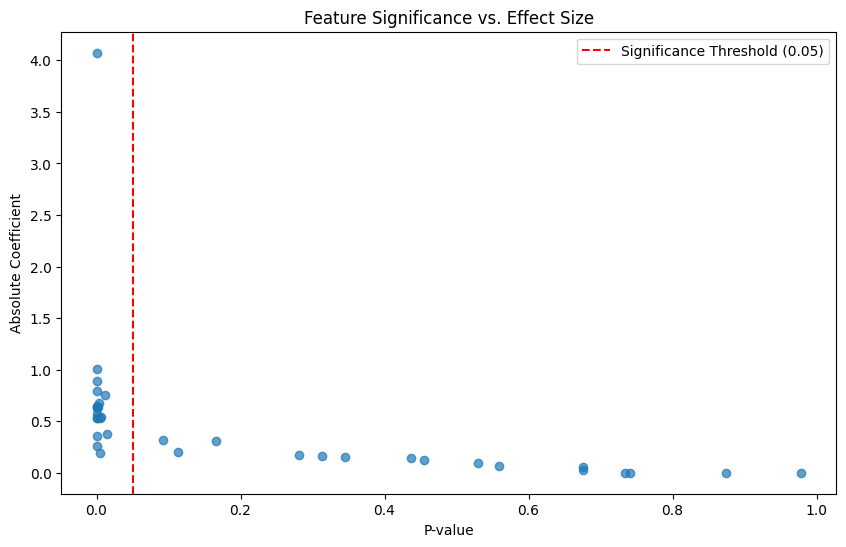

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(results_df["P-value"], results_df["abs_coef"], alpha=0.7)
plt.axvline(x=0.05, color="red", linestyle="--", label="Significance Threshold (0.05)")
plt.xlabel("P-value")
plt.ylabel("Absolute Coefficient")
plt.title("Feature Significance vs. Effect Size")
plt.legend()
plt.show()

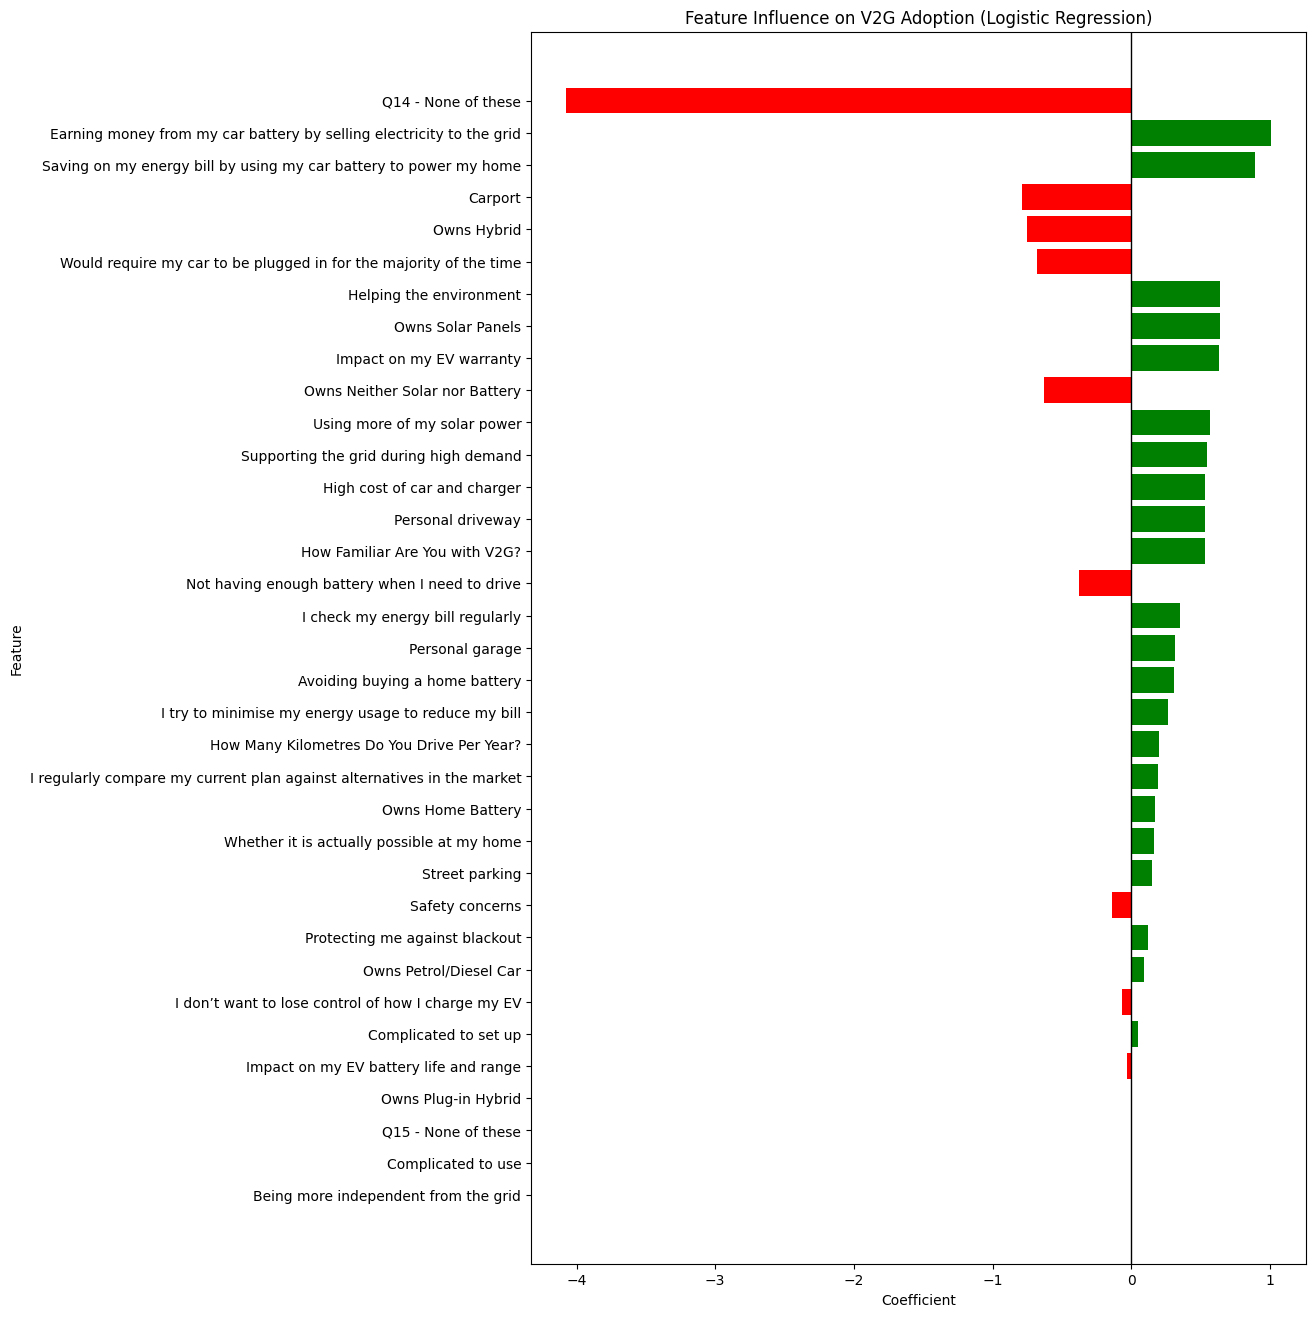

In [21]:
# Sort by absolute coefficient value
results_df_sorted = results_df.sort_values(by="abs_coef", ascending=True)

# Plot
plt.figure(figsize=(10, 16))
plt.barh(results_df_sorted["Feature"], results_df_sorted["Coefficient"], color=["green" if x > 0 else "red" for x in results_df_sorted["Coefficient"]])
plt.axvline(0, color="black", linewidth=1)  # Add a vertical line at 0 for reference
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title("Feature Influence on V2G Adoption (Logistic Regression)")
plt.show()


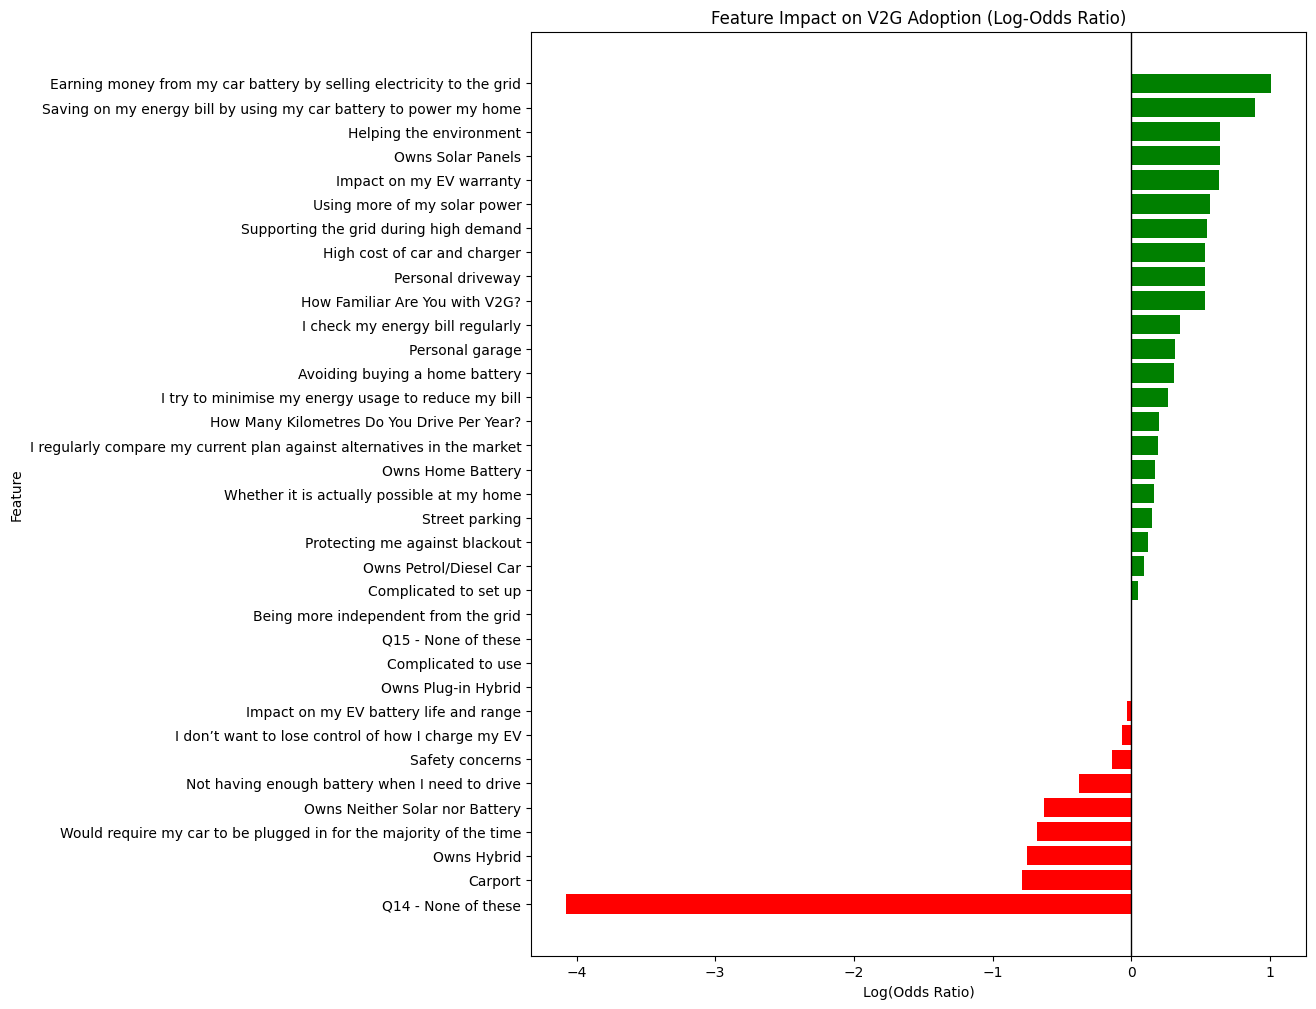

In [22]:
# Sort by odds ratio
results_df_sorted = results_df.sort_values(by="Odds Ratio", ascending=True)

# Plot
plt.figure(figsize=(10, 12))
plt.barh(results_df_sorted["Feature"], np.log(results_df_sorted["Odds Ratio"]),color=["green" if x > 0 else "red" for x in results_df_sorted["Coefficient"]])
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Log(Odds Ratio)")
plt.ylabel("Feature")
plt.title("Feature Impact on V2G Adoption (Log-Odds Ratio)")
plt.show()


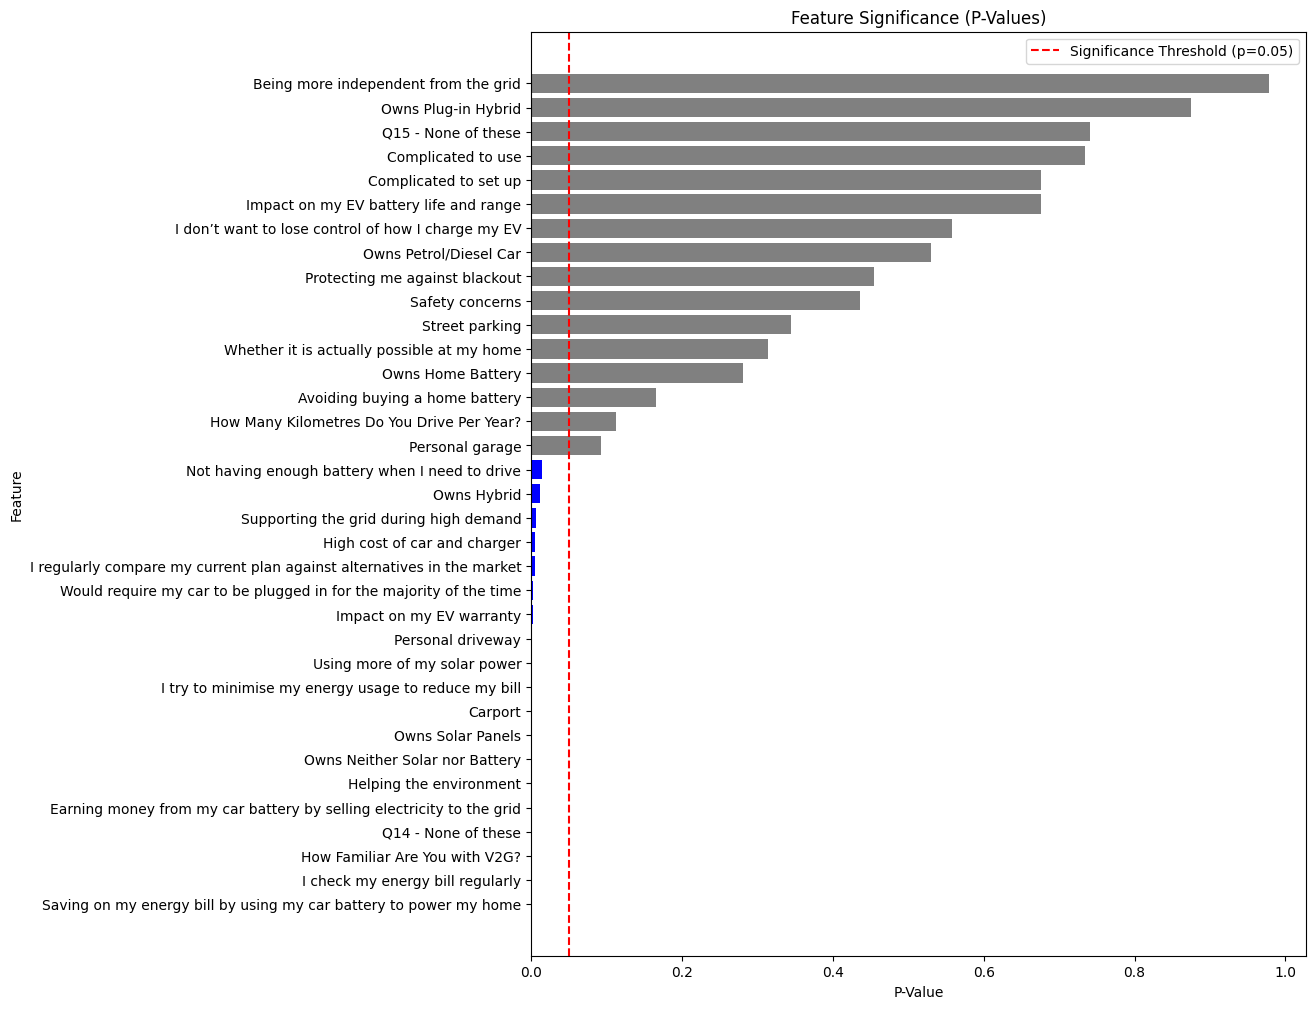

In [23]:
import matplotlib.pyplot as plt

# Sort by p-value
results_df_sorted = results_df.sort_values(by="P-value", ascending=True)

# Plot
plt.figure(figsize=(10, 12))
plt.barh(results_df_sorted["Feature"], results_df_sorted["P-value"], color=["blue" if p < 0.05 else "gray" for p in results_df_sorted["P-value"]])
plt.axvline(0.05, color="red", linestyle="dashed", linewidth=1.5, label="Significance Threshold (p=0.05)")
plt.xlabel("P-Value")
plt.ylabel("Feature")
plt.title("Feature Significance (P-Values)")
plt.legend()
plt.show()


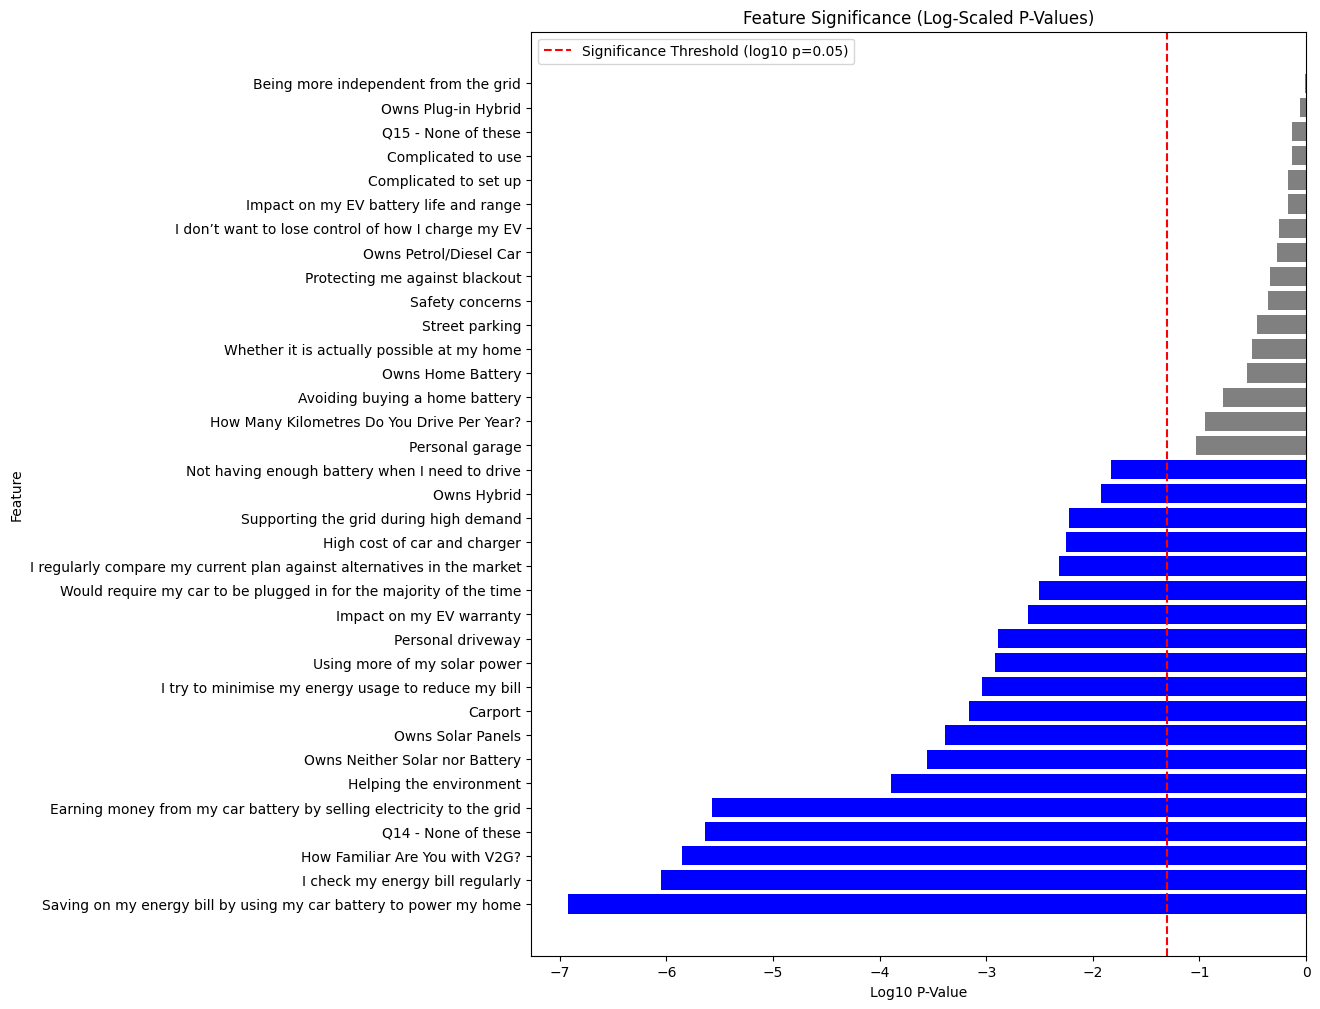

In [24]:
plt.figure(figsize=(10, 12))
plt.barh(results_df_sorted["Feature"], np.log10(results_df_sorted["P-value"]), color=["blue" if p < 0.05 else "gray" for p in results_df_sorted["P-value"]])
plt.axvline(np.log10(0.05), color="red", linestyle="dashed", linewidth=1.5, label="Significance Threshold (log10 p=0.05)")
plt.xlabel("Log10 P-Value")
plt.ylabel("Feature")
plt.title("Feature Significance (Log-Scaled P-Values)")
plt.legend()
plt.show()

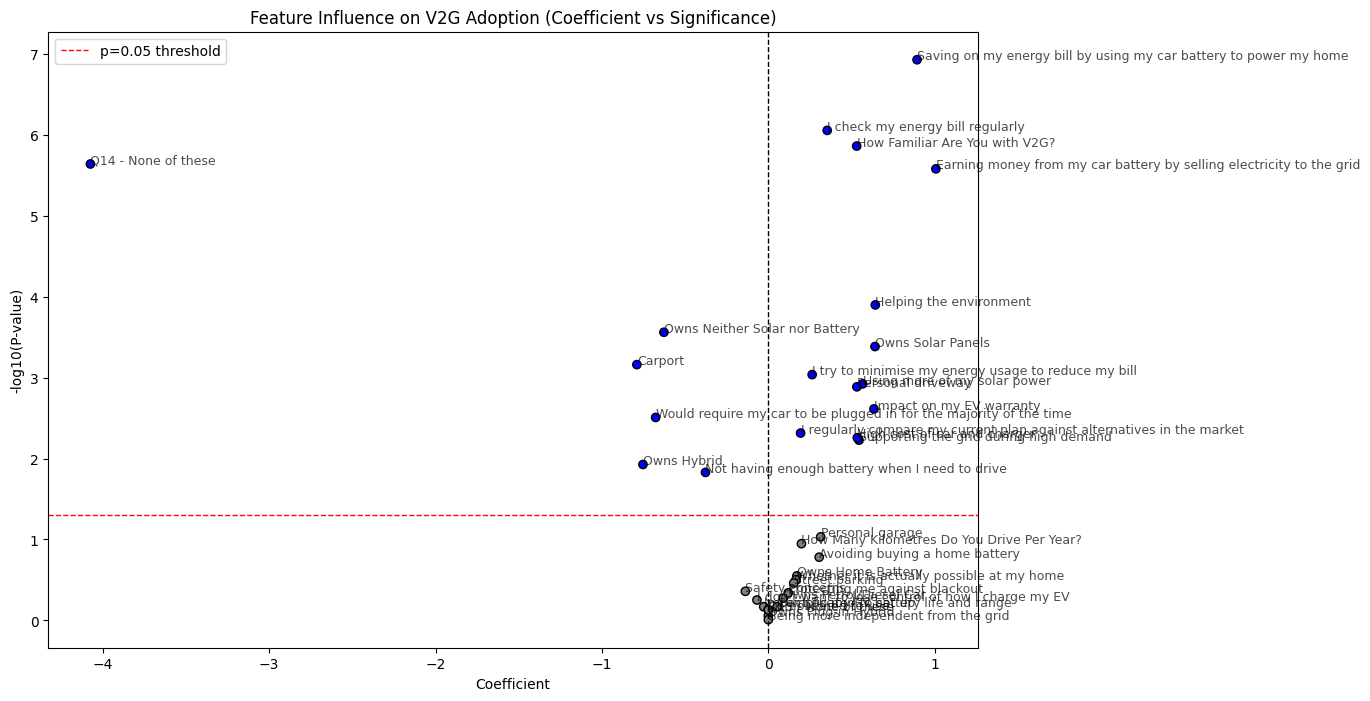

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Compute -log(p-value) for better visualization
results_df["-log(p)"] = -np.log10(results_df["P-value"])

# Define colors based on significance threshold (p < 0.05)
colors = ["blue" if p < 0.05 else "gray" for p in results_df["P-value"]]

# Create scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(results_df["Coefficient"], results_df["-log(p)"], c=colors, edgecolors="black")

# Add labels for key points
for i, txt in enumerate(results_df["Feature"]):
    plt.annotate(txt, (results_df["Coefficient"].iloc[i], results_df["-log(p)"].iloc[i]), fontsize=9, alpha=0.7)

# Reference lines
plt.axvline(0, color="black", linestyle="--", linewidth=1)  # Vertical line at zero coefficient
plt.axhline(-np.log10(0.05), color="red", linestyle="--", linewidth=1, label="p=0.05 threshold")  # Horizontal line at p=0.05

# Labels & title
plt.xlabel("Coefficient")
plt.ylabel("-log10(P-value)")
plt.title("Feature Influence on V2G Adoption (Coefficient vs Significance)")
plt.legend()
plt.show()


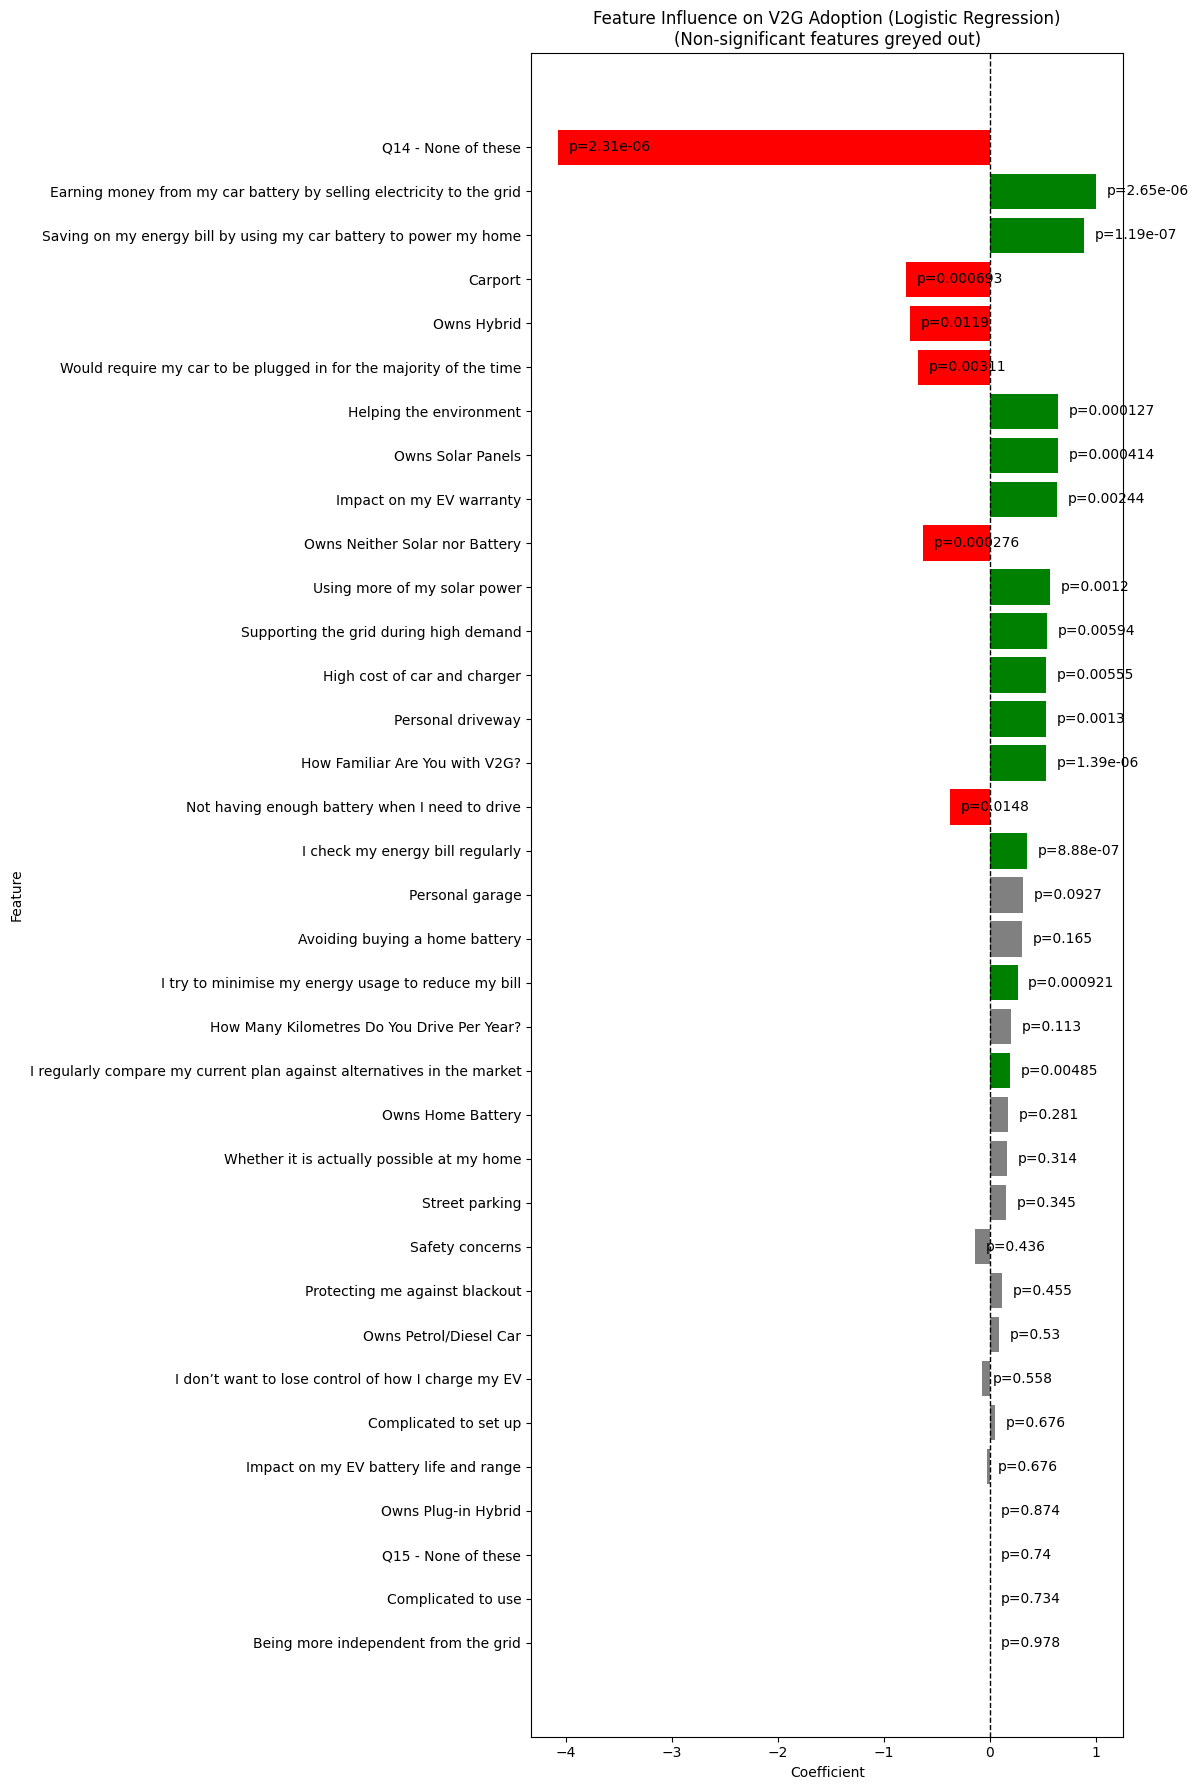

In [26]:
import matplotlib.pyplot as plt

# Sort by absolute coefficient value
results_df_sorted = results_df.sort_values(by="abs_coef", ascending=True)

# Define colors: Gray for p >= 0.05, Green for positive, Red for negative
colors = [
    "gray" if p >= 0.05 else ("green" if coef > 0 else "red")
    for p, coef in zip(results_df_sorted["P-value"], results_df_sorted["Coefficient"])
]

# Create figure
plt.figure(figsize=(12, 18))
bars = plt.barh(results_df_sorted["Feature"], results_df_sorted["Coefficient"], color=colors)

# Add p-value annotations on the right side
for bar, p_value in zip(bars, results_df_sorted["P-value"]):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, f"p={p_value:.3g}", va='center', fontsize=10)

# Reference line at zero
plt.axvline(0, color="black", linewidth=1, linestyle="--")

# Labels and title
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title("Feature Influence on V2G Adoption (Logistic Regression)\n(Non-significant features greyed out)")
plt.tight_layout()  # Adjust layout to prevent text cutoff

# Show the plot
plt.show()


# 4. Binomial Logistic Regression

## 4.1. Filtering my df based on the previous p-value analysis

In [27]:
# Get the list of significant features (p < 0.05)
significant_features = results_df[results_df["P-value"] < 0.05]["Feature"].tolist()

# Map back to original column names using feature_label_map
significant_columns = [key for key, value in feature_label_map.items() if value in significant_features]

# Ensure the target variable is retained
significant_columns.append(target_variable)

# Create a new filtered list for columns_of_interest
columns_of_interest_filtered = [
    col for col in columns_of_interest if col in significant_columns
]

# Display before and after
print(f"Original columns count: {len(columns_of_interest)}")
print(f"Filtered columns count: {len(columns_of_interest_filtered)}")

Original columns count: 47
Filtered columns count: 20


In [28]:
filtered_df = df[columns_of_interest_filtered]

In [29]:
filtered_df

,Q9,Q8_1,Q8_99,Q1_4,Q3_1,Q3_3,Q14_1,Q14_2,Q14_3,Q14_4,Q14_5,Q14_99,Q15_1,Q15_6,Q15_7,Q15_9,Q7_1,Q7_2,Q7_3,Q10_2
1,Very familiar,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,Strongly agree,Strongly agree,Somewhat agree,1
4,Very familiar,1,0,1,1,0,1,0,0,0,1,0,1,0,1,0,Strongly agree,Strongly agree,Somewhat agree,1
5,Very familiar,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,Strongly agree,Strongly agree,Somewhat agree,1
9,Very familiar,0,1,0,0,1,0,1,1,0,1,0,1,0,0,0,Neither agree nor disagree,Somewhat agree,Somewhat agree,1
10,Somewhat familiar,1,0,0,1,0,1,0,0,1,0,0,0,1,1,0,Strongly agree,Strongly agree,Somewhat agree,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1352,Very familiar,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,Strongly agree,Strongly agree,Somewhat agree,1
1353,Somewhat familiar,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0,Strongly agree,Strongly agree,Neither agree nor disagree,1
1355,Very familiar,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,Strongly agree,Neither agree nor disagree,Neither agree nor disagree,1
1356,Very familiar,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,1


## 4.2. Running regression

In [30]:
filtered_df['Q6ax1_1'] = filtered_df['Q6ax1_1'].fillna(0)
filtered_df['Q6ax3_2'] = filtered_df['Q6ax3_2'].fillna(0)

KeyError: 'Q6ax1_1'

In [31]:
print("Checking if any feature column is missing data...")
print(filtered_df.isnull().sum())

print("\nChecking unique values in target variable (Q10_2):")
print(filtered_df[target_variable].unique())

print("\nChecking number of non-missing rows in dataset:")
valid_rows = filtered_df.dropna().shape[0]
print(f"Valid rows: {valid_rows} / {df.shape[0]}")


Checking if any feature column is missing data...
Q9        0
Q8_1      0
Q8_99     0
Q1_4      0
Q3_1      0
Q3_3      0
Q14_1     0
Q14_2     0
Q14_3     0
Q14_4     0
Q14_5     0
Q14_99    0
Q15_1     0
Q15_6     0
Q15_7     0
Q15_9     0
Q7_1      0
Q7_2      0
Q7_3      0
Q10_2     0
dtype: int64

Checking unique values in target variable (Q10_2):
[1 0]

Checking number of non-missing rows in dataset:
Valid rows: 768 / 768


In [32]:
model_binary, X_train, y_train, X_test, y_test = build_v2g_model_binary_from_df(
    filtered_df,  
    columns_of_interest_filtered,  # Keep same features
    target_variable,  
    TRANSFORMERS_q6a,  
    do_normalize=True,
    test_split_ratio=0.2
)

Unique values in y_train: (array([0, 1]), array([158, 456], dtype=int64))
Unique values in y_test: (array([0, 1]), array([ 30, 124], dtype=int64))
Train Accuracy: 80.29%
Test Accuracy: 86.36%


In [33]:
filtered_df

,Q9,Q8_1,Q8_99,Q1_4,Q3_1,Q3_3,Q14_1,Q14_2,Q14_3,Q14_4,Q14_5,Q14_99,Q15_1,Q15_6,Q15_7,Q15_9,Q7_1,Q7_2,Q7_3,Q10_2
1,Very familiar,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,Strongly agree,Strongly agree,Somewhat agree,1
4,Very familiar,1,0,1,1,0,1,0,0,0,1,0,1,0,1,0,Strongly agree,Strongly agree,Somewhat agree,1
5,Very familiar,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,Strongly agree,Strongly agree,Somewhat agree,1
9,Very familiar,0,1,0,0,1,0,1,1,0,1,0,1,0,0,0,Neither agree nor disagree,Somewhat agree,Somewhat agree,1
10,Somewhat familiar,1,0,0,1,0,1,0,0,1,0,0,0,1,1,0,Strongly agree,Strongly agree,Somewhat agree,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1352,Very familiar,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,Strongly agree,Strongly agree,Somewhat agree,1
1353,Somewhat familiar,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0,Strongly agree,Strongly agree,Neither agree nor disagree,1
1355,Very familiar,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,Strongly agree,Neither agree nor disagree,Neither agree nor disagree,1
1356,Very familiar,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,1


# 5. Visualisation of results

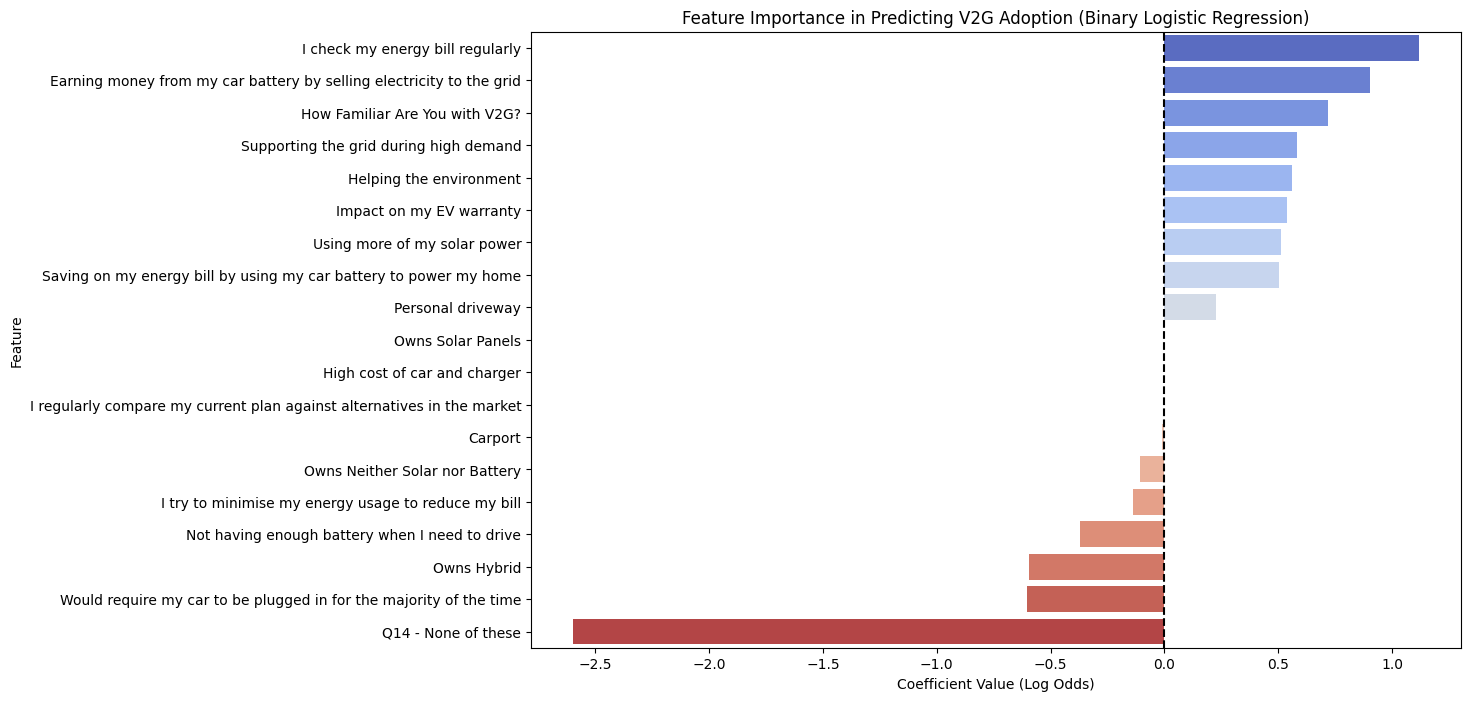

In [40]:
# Extract coefficients
coefs_binary = model_binary.coef_[0]  # Shape: (1, n_features), so take [0]

# Create DataFrame for visualization
coefs_binary_df = pd.DataFrame({'Feature': columns_of_interest_filtered, 'Coefficient': coefs_binary})
coefs_binary_df.sort_values(by="Coefficient", ascending=False, inplace=True)
coefs_binary_df["Feature"] = coefs_binary_df["Feature"].map(feature_label_map)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x="Coefficient", y="Feature", data=coefs_binary_df, palette="coolwarm")
plt.title("Feature Importance in Predicting V2G Adoption (Binary Logistic Regression)")
plt.xlabel("Coefficient Value (Log Odds)")
plt.ylabel("Feature")
plt.axvline(x=0, color='black', linestyle='--')  # Reference line for neutral impact
plt.show()

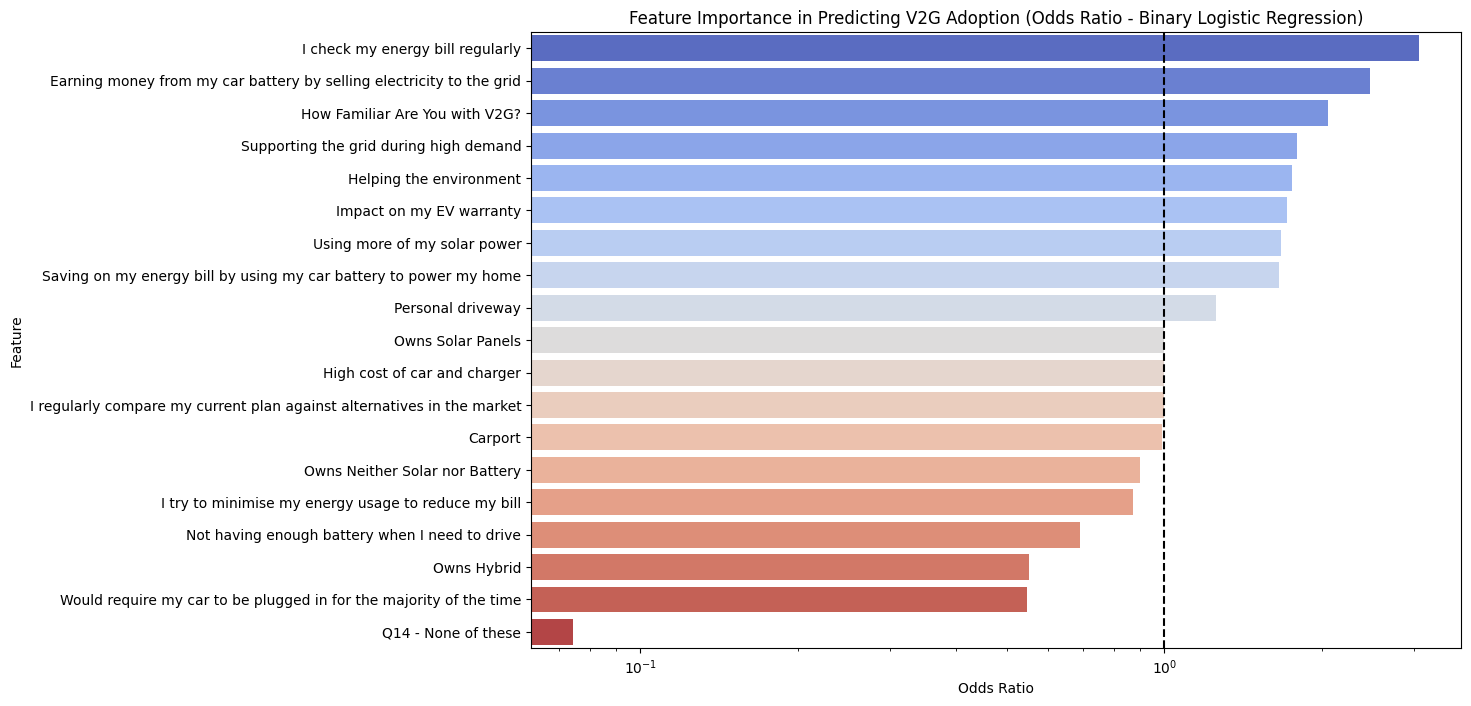

In [35]:
# Extract coefficients
coefs_binary = model_binary.coef_[0]  # Shape: (1, n_features), so take [0]

# Convert to Odds Ratios
odds_ratios = np.exp(coefs_binary)

# Create DataFrame for visualization
coefs_binary_df = pd.DataFrame({'Feature': columns_of_interest_filtered, 'Odds Ratio': odds_ratios})
coefs_binary_df.sort_values(by="Odds Ratio", ascending=False, inplace=True)
coefs_binary_df["Feature"] = coefs_binary_df["Feature"].map(feature_label_map)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x="Odds Ratio", y="Feature", data=coefs_binary_df, palette="coolwarm")
plt.title("Feature Importance in Predicting V2G Adoption (Odds Ratio - Binary Logistic Regression)")
plt.xlabel("Odds Ratio")
plt.ylabel("Feature")
plt.axvline(x=1, color='black', linestyle='--')  # Reference line at 1 (neutral effect)
plt.xscale("log")  # Log scale for better visualization
plt.show()


In [41]:
coefs_binary_df

,Feature,Coefficient
16,I check my energy bill regularly,1.117420
6,Earning money from my car battery by selling e...,0.902909
0,How Familiar Are You with V2G?,0.716801
10,Supporting the grid during high demand,0.580410
8,Helping the environment,0.560089
14,Impact on my EV warranty,0.539950
9,Using more of my solar power,0.511609
7,Saving on my energy bill by using my car batte...,0.504441
4,Personal driveway,0.226409
1,Owns Solar Panels,0.000000


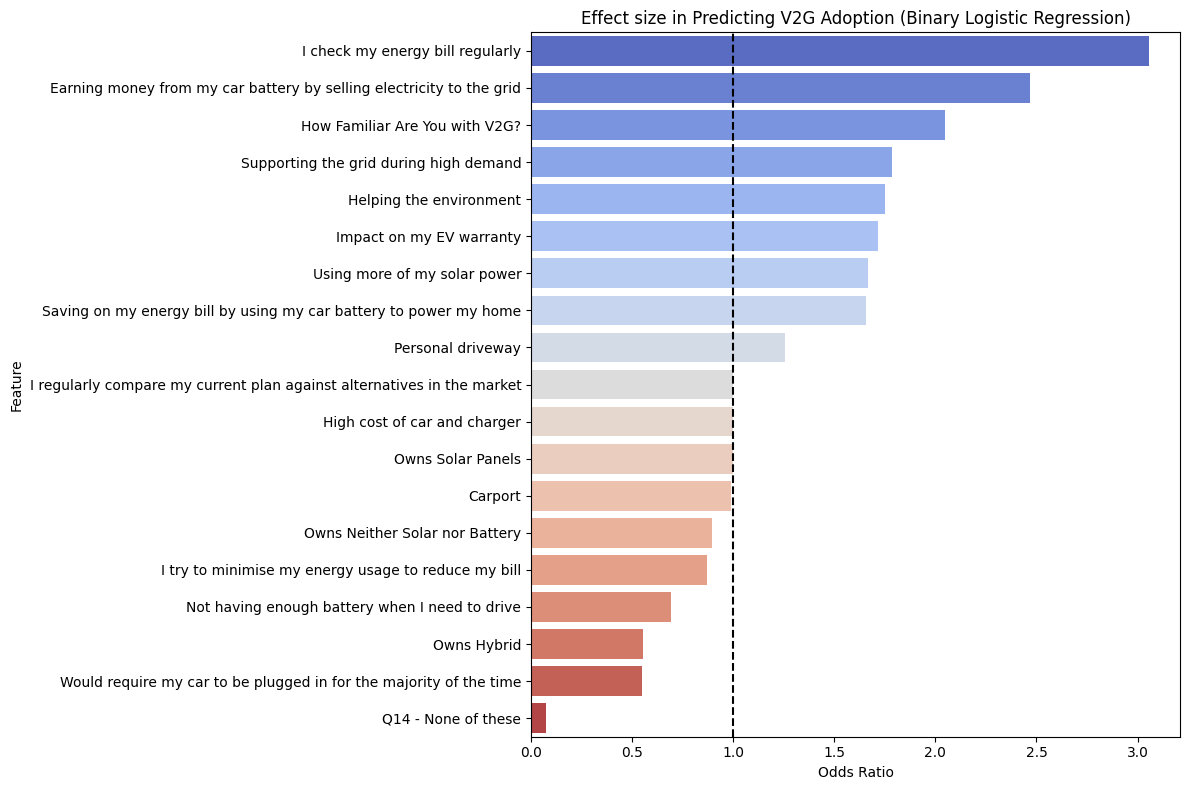

In [42]:
# 1. Compute Odds Ratio
coefs_binary_df["Odds Ratio"] = np.exp(coefs_binary_df["Coefficient"])

# 2. Sort by Odds Ratio if you prefer (so that the strongest effects appear at the top/bottom)
coefs_binary_df.sort_values(by="Odds Ratio", ascending=False, inplace=True)

# 3. Plot using Odds Ratio
plt.figure(figsize=(12, 8))
sns.barplot(x="Odds Ratio", y="Feature", data=coefs_binary_df, palette="coolwarm")

# 4. Add a vertical reference line at x=1 (since OR=1 means "no effect")
plt.axvline(x=1, color='black', linestyle='--')

# 5. Label and show
plt.title("Effect size in Predicting V2G Adoption (Binary Logistic Regression)")
plt.xlabel("Odds Ratio")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [37]:
# Sort features by absolute coefficient magnitude for better visualization
coefs_binary_df["abs_coef"] = coefs_binary_df["Coefficient"].abs()
coefs_binary_df = coefs_binary_df.sort_values(by="abs_coef", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x="Coefficient", y="Feature", data=coefs_binary_df, palette="coolwarm")
plt.title("Feature Importance in Predicting V2G Adoption (Binary Logistic Regression)")
plt.xlabel("Coefficient Value (Log Odds)")
plt.ylabel("Feature (Survey Question)")
plt.axvline(x=0, color='black', linestyle='--')  # Reference line for neutral impact
plt.show()

KeyError: 'Coefficient'

In [43]:
# Predict on test data
y_pred_binary = model_binary.predict(X_test)

# Compute accuracy
accuracy_binary = accuracy_score(y_test, y_pred_binary)
print(f"Model Accuracy: {accuracy_binary:.2%}")

Model Accuracy: 86.36%


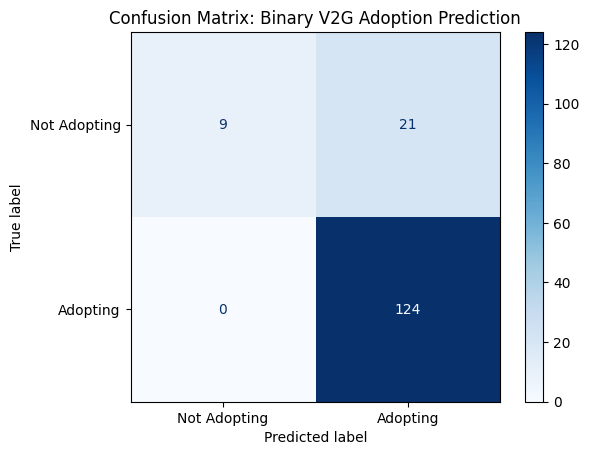

In [44]:
cm_binary = confusion_matrix(y_test, y_pred_binary, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm_binary, display_labels=["Not Adopting", "Adopting"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix: Binary V2G Adoption Prediction")
plt.show()

In [ ]:
df.loc[df["Q1_2"] == 0, q6a_ev] = 0  # Set EV charging times to 0 if they don't own an EV
df.loc[df["Q1_1"] == 0, q6a_petrol] = 0  # Set Petrol charging times to 0 if they don't own a Petrol car

In [ ]:
valid_rows = df[significant_columns + [target_variable]].dropna().shape[0]
print(f"Valid rows: {valid_rows} / {df.shape[0]}")

In [ ]:
# Train model with binary logistic regression
model_binary, X_train, y_train, X_test, y_test = build_v2g_model_binary_from_df(
    df,  
    significant_columns,  # Keep same features
    target_variable,  
    TRANSFORMERS_q6a,  
    do_normalize=True,
    test_split_ratio=0.2
)

In [ ]:
# Extract coefficients
coefs_binary = model_binary.coef_[0]  # Shape: (1, n_features), so take [0]

# Create DataFrame for visualization
coefs_binary_df = pd.DataFrame({'Feature': significant_columns, 'Coefficient': coefs_binary})
coefs_binary_df.sort_values(by="Coefficient", ascending=False, inplace=True)
coefs_binary_df["Feature"] = coefs_binary_df["Feature"].map(feature_label_map)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x="Coefficient", y="Feature", data=coefs_binary_df, palette="coolwarm")
plt.title("Feature Importance in Predicting V2G Adoption (Binary Logistic Regression)")
plt.xlabel("Coefficient Value (Log Odds)")
plt.ylabel("Feature")
plt.axvline(x=0, color='black', linestyle='--')  # Reference line for neutral impact
plt.show()

In [ ]:
coefs_binary_df

# 5. Regression per segmentation

In [ ]:
q1_columns = ["Q1_1", "Q1_2", "Q1_3", "Q1_4", "Q1_99"]  # Add all binary ownership columns
df[q1_columns] = df[q1_columns].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

In [ ]:
# Define segments based on ownership
ev_owners = df[df["Q1_2"] == 1]  # People who own EVs
petrol_owners = df[df["Q1_1"] == 1]  # People who own Petrol/Diesel
# hybrid_owners = df[df["Q1_4"] == 1]  # People who own Hybrids
# phev_owners = df[df["Q1_3"] == 1]  # People who own Plug-in Hybrids

In [ ]:
# Multi-vehicle owners (People who own 2 or more types)
ev_petrol_owners = df[(df[["Q1_1", "Q1_2"]].sum(axis=1) > 1)]

# Define input variables per group
input_variables_ev = input_variables + q6a_ev
input_variables_petrol = input_variables + q6a_petrol
# input_variables_hybrid = input_variables + q6a_hybrid
# input_variables_phev = input_variables + q6a_plughyb
input_variables_multi = input_variables + q6a_ev + q6a_petrol


## 5.1. For EV owners

In [ ]:
print("Checking if any feature column is missing data...")
print(ev_owners[input_variables_extended].isnull().sum())

print("\nChecking unique values in target variable (Q10_2):")
print(ev_owners[target_variable].unique())

print("\nChecking number of non-missing rows in dataset:")
valid_rows = ev_owners[input_variables_extended + [target_variable]].dropna().shape[0]
print(f"Valid rows: {valid_rows} / {ev_owners.shape[0]}")


In [ ]:
# Run logistic regression for each segment
def run_segmented_logistic_regression(df_segment, input_vars, vehicle_type):
    print(f"Running Logistic Regression for {vehicle_type} Owners")
    
    # Train model
    model, X_train, y_train, X_test, y_test = build_v2g_model_binary_from_df(
        df_segment,
        input_vars,
        target_variable,
        TRANSFORMERS_q6a,
        do_normalize=True,
        test_split_ratio=0.2
    )
    
    # Extract Coefficients
    coefs_binary = model.coef_[0]  
    coefs_binary_df = pd.DataFrame({'Feature': input_vars, 'Coefficient': coefs_binary})
    coefs_binary_df.sort_values(by="Coefficient", ascending=False, inplace=True)
    coefs_binary_df["Feature"] = coefs_binary_df["Feature"].map(feature_label_map)
    
    print("\n🔍 Top Predictors for V2G Adoption in", vehicle_type, "Owners:")
    display(coefs_binary_df)  # Show top predictors for this group

In [ ]:
run_segmented_logistic_regression(ev_owners, input_variables_ev, "EV")
run_segmented_logistic_regression(petrol_owners, input_variables_petrol, "Petrol")
run_segmented_logistic_regression(ev_petrol_owners, input_variables_multi, "Multi-Vehicle")